# Equipe:
Cleverton, Gustavo Libel, Igor

In [1]:
from __future__ import print_function

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
sns.set(font_scale=1.2)

import warnings
warnings.filterwarnings('ignore')

import math

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics

get_ipython().magic(u'matplotlib inline') #para imprimir no próprio notebook

# Visualização

In [2]:
#Funções auxiliares
def plot_correlation_map( df, figsize = (12,10)):
    corr = df.corr().round(2)
    _ , ax = plt.subplots(figsize = figsize)
    cmap = sns.diverging_palette(220,10, as_cmap=True)
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={'shrink':.9}, 
        ax=ax, 
        annot=True, 
        annot_kws={'fontsize':12}
    )
    
def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get('row', None)
    col = kwargs.get('col', None)
    facet = sns.FacetGrid(df,row = row, col=col)
    facet.map(sns.barplot, cat, target)
    facet.add_legend()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

In [3]:
#Adaptado de https://www.kaggle.com/sachinkulkarni/titanic/an-interactive-data-science-tutorial
#Carrega a base de dados
train = pd.read_csv('train.csv')
test  = pd.read_csv('test.csv')
full = train.append(test , ignore_index = True)
print("Datasets:\nCompleto: " , full.shape, "\nTreinamento:", train.shape,"\nTeste:",test.shape)

Datasets:
Completo:  (1309, 12) 
Treinamento: (891, 12) 
Teste: (418, 11)


In [4]:
#Identifica as características presentes
train.columns.values

#Descrição das variáveis
#We've got a sense of our variables, their class type, and the first few observations of each. We know we're working with 1309 observations of 12 variables. To make things a bit more explicit since a couple of the variable names aren't 100% illuminating, here's what we've got to deal with:
#Variable Description
#Survived: Survived (1) or died (0)
#Pclass: Passenger's class
#Name: Passenger's name
#Sex: Passenger's sex
#Age: Passenger's age
#SibSp: Number of siblings/spouses aboard
#Parch: Number of parents/children aboard
#Ticket: Ticket number
#Fare: Fare
#Cabin: Cabin
#Embarked: Port of embarkation

array(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], dtype=object)

In [5]:
#Análise dos dados. Observe que é possível identificar dados inconsistentes. Por exemplo, idade mínima de 0.42! -- Será?
#Ver "Sobre as idades"
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


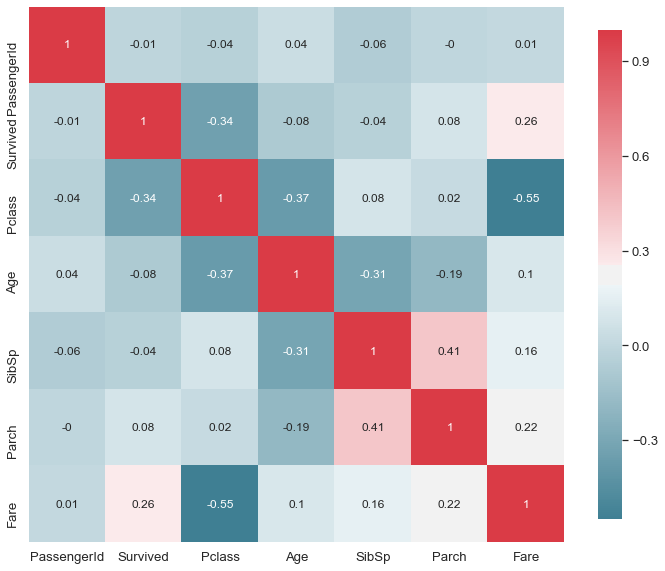

In [6]:
#Correlação entre as características.
#Pode dar uma ideia do que está relacionado com o que.
plot_correlation_map(train)

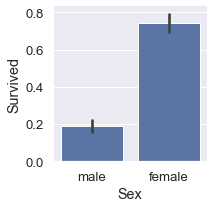

In [7]:
#Distribuição das amostras dentro de uma mesma classe
#Visualize a "Survival Rate" em relação aos seguintes atributos: Embarked, Sex, Pclass, SibSp, Parch
plot_categories(train, cat = 'Sex', target = 'Survived')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021A9A272400>,
      dtype=object)

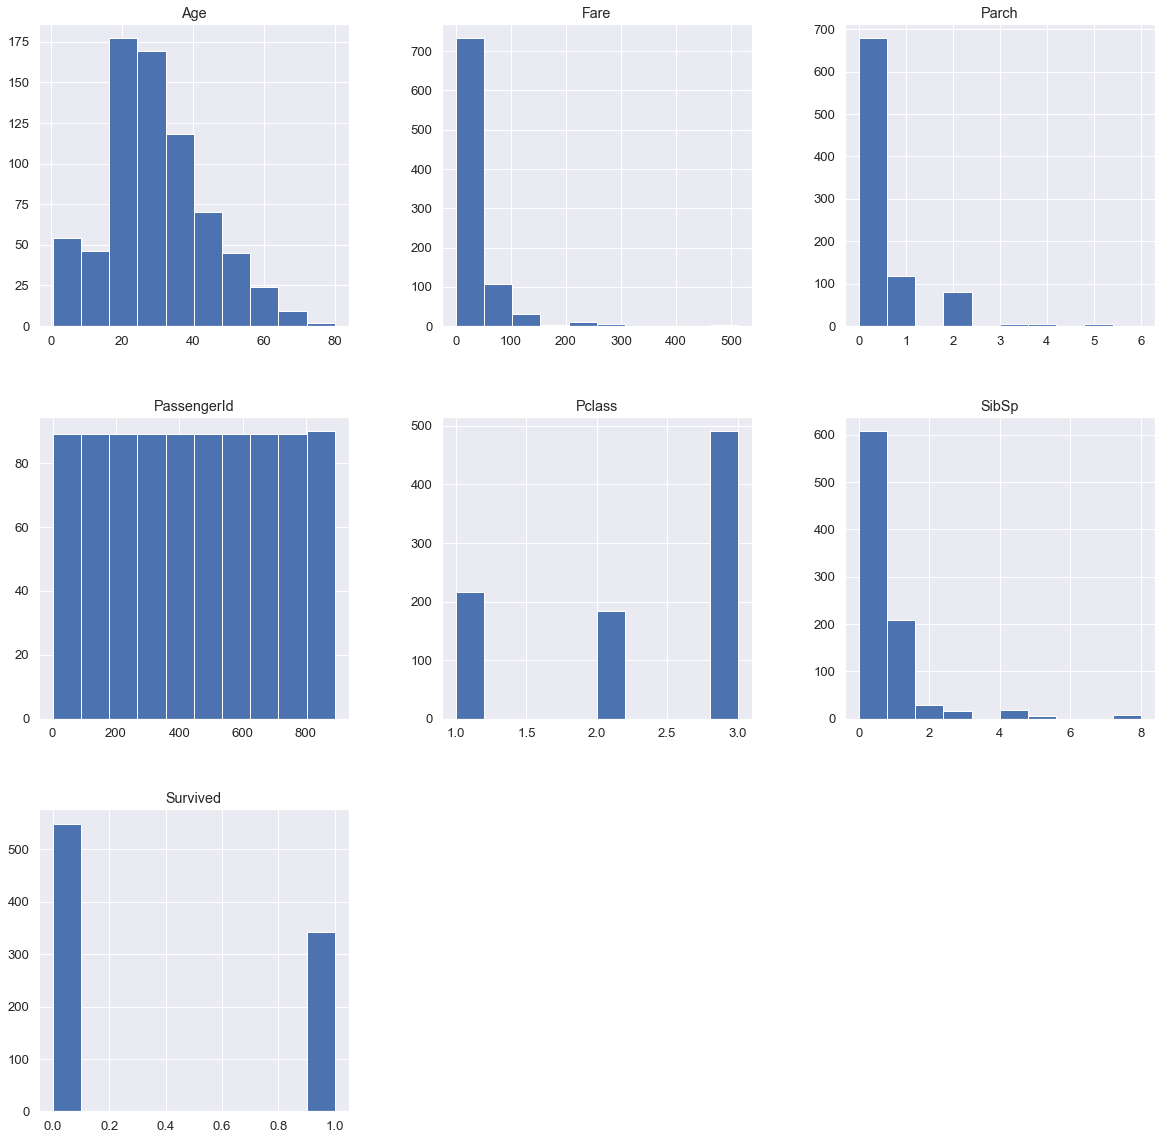

In [8]:
train.hist(figsize=(20,20))

# Ajustando os dados

### Novas colunas

In [9]:
#Altera o atributo "Sex" de valores nominais (Male/Female) para 0 e 1
full["Male"] = (full.Sex == "male").astype(int)
full = full.drop(['Sex'],axis=1)
full.head(2)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,SibSp,Survived,Ticket,Male
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,1,0.0,A/5 21171,1
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,1,1.0,PC 17599,0


In [10]:
#Cria uma nova variável para cada valor único de "Embarked" (no caso, Embarked_C  Embarked_Q  Embarked_S)
embarked = pd.get_dummies(full.Embarked, prefix='Embarked')

#Cria uma nova variável para cada valor único de "Pclass"
pclass = pd.get_dummies(full.Pclass , prefix='Pclass' )

print(embarked.sum())
print(pclass.sum())

#junta novas colunas e remove antigas
full = pd.concat([full,embarked,pclass],axis=1)
full = full.drop(['Embarked','Pclass'],axis=1)
full.head(2)

Embarked_C    270
Embarked_Q    123
Embarked_S    914
dtype: int64
Pclass_1    323
Pclass_2    277
Pclass_3    709
dtype: int64


,Age,Cabin,Fare,Name,Parch,PassengerId,SibSp,Survived,Ticket,Male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,22.0,NaN,7.2500,"Braund, Mr. Owen Harris",0,1,1,0.0,A/5 21171,1,0,0,1,0,0,1
1,38.0,C85,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,1.0,PC 17599,0,1,0,0,1,0,0


In [11]:
#As distinções refletiam o status social e podem ser utilziados para prever a probabilidade de sobrevivência

title = pd.DataFrame()

#Extrai o título de cada nome
title['Title'] = full['Name'].map(lambda name: name.split(',')[1].split('.')[0].strip())

#Lista agregada de títulos
Title_Dictionary = {
                    "Capt":       "Officer",#Officer
                    "Col":        "Officer",#Officer
                    "Major":      "Officer",#Officer
                    "Jonkheer":   "Royalty",#Royalty
                    "Don":        "Royalty",#Royalty
                    "Sir" :       "Royalty",#Royalty
                    "Dr":         "Officer",#Officer
                    "Rev":        "Officer",#Officer
                    "the Countess":"Royalty",#Royalty
                    "Dona":       "Royalty",#Royalty
                    "Mme":        "Mrs",
                    "Mlle":       "Miss",
                    "Ms":         "Mrs",
                    "Mr" :        "Mr",
                    "Mrs" :       "Mrs",
                    "Miss" :      "Miss",
                    "Master" :    "Master",
                    "Lady" :      "Royalty"#Royalty
                    }

#Faz o mapeamento de cada título
title['Title'] = title.Title.map(Title_Dictionary)
#Cria uma nova variável para cada título
title = pd.get_dummies(title.Title)

print(title.sum())

#junta novas colunas 
full = pd.concat([full,title],axis=1)
full = full.drop(['Name'],axis=1)
full.head(2)

Master      61
Miss       262
Mr         757
Mrs        200
Officer     23
Royalty      6
dtype: int64


,Age,Cabin,Fare,Parch,PassengerId,SibSp,Survived,Ticket,Male,Embarked_C,...,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Master,Miss,Mr,Mrs,Officer,Royalty
0,22.0,NaN,7.2500,0,1,1,0.0,A/5 21171,1,0,...,1,0,0,1,0,0,1,0,0,0
1,38.0,C85,71.2833,0,2,1,1.0,PC 17599,0,1,...,0,1,0,0,0,0,0,1,0,0


In [12]:
#Extrai a categoria da cabine a partir do número
cabin = pd.DataFrame()

#Substitui dados faltantes por "U" (Uknown)
cabin['Cabin'] = full.Cabin.fillna( 'U' )

#Mapeia cada valor de cabine com a letra
cabin['Cabin'] = cabin['Cabin'].map(lambda c : c[0])

#Cria uma variável para cada categoria
cabin = pd.get_dummies(cabin['Cabin'] , prefix = 'Cabin')

print(cabin.sum())
#junta pois tem poucos dados 
cabin['Cabin_AB'] = cabin['Cabin_A']+cabin['Cabin_B']
cabin['Cabin_DE'] = cabin['Cabin_D']+cabin['Cabin_E']
cabin['Cabin_FG'] = cabin['Cabin_F']+cabin['Cabin_G']
cabin = cabin.drop(["Cabin_A","Cabin_B","Cabin_D","Cabin_E","Cabin_F","Cabin_G","Cabin_T"],axis=1)

print(cabin.sum())

#junta novas colunas e remove antigas
full = pd.concat([full,cabin],axis=1)
full = full.drop(['Cabin'],axis=1)

full.head(2)

Cabin_A      22
Cabin_B      65
Cabin_C      94
Cabin_D      46
Cabin_E      41
Cabin_F      21
Cabin_G       5
Cabin_T       1
Cabin_U    1014
dtype: int64
Cabin_C       94
Cabin_U     1014
Cabin_AB      87
Cabin_DE      87
Cabin_FG      26
dtype: int64


,Age,Fare,Parch,PassengerId,SibSp,Survived,Ticket,Male,Embarked_C,Embarked_Q,...,Miss,Mr,Mrs,Officer,Royalty,Cabin_C,Cabin_U,Cabin_AB,Cabin_DE,Cabin_FG
0,22.0,7.2500,0,1,1,0.0,A/5 21171,1,0,0,...,0,1,0,0,0,0,1,0,0,0
1,38.0,71.2833,0,2,1,1.0,PC 17599,0,1,0,...,0,0,1,0,0,1,0,0,0,0


A nomenclatura das cabines está relacionada com a sua posição no navio, assim, unimos as cabines mais próximas. 
<img src="cabines.png" width=350>

In [13]:
#Ticket: Removido por possuir poucas amostras por cada classe
'''
#Caso não tenha prefixo, retorna XXX
def cleanTicket( ticket ):
    ticket = ticket.replace('.', '')
    ticket = ticket.replace('/', '')
    ticket = ticket.split()
    ticket = map( lambda t : t.strip() , ticket )
    ticket = list(filter( lambda t : not t.isdigit() , ticket ))
    if len( ticket ) > 0:
        return ticket[0]
    else: 
        return 'XXX'

ticket = pd.DataFrame()

#Cria uma nova variável para cada caso
ticket[ 'Ticket' ] = full[ 'Ticket' ].map( cleanTicket )
ticket = pd.get_dummies( ticket[ 'Ticket' ] , prefix = 'Ticket' )
print(ticket.sum())
'''
#junta novas colunas e remove antigas
#full = pd.concat([full,ticket],axis=1)

full = full.drop(['Ticket'],axis=1)
#full.head(2)
#ticket.shape

Decidimos não adicionar os tickets pois adiciona muitas colunas com pouco valor.

In [14]:
#familySize: Removido pela informação ser repetida
'''
#Cria variáveis para representar o tamanho da família e também cada categoria
family = pd.DataFrame()

#Cria nova característica que representa o tamanho da família (quantidade de membros)
family['FamilySize'] = full['Parch'] + full['SibSp'] + 1

#Cria nova características para representar o tipo de família 
family['Family_Single'] = family['FamilySize'].map(lambda s : 1 if s == 1 else 0)
#family['Family_Small']  = family['FamilySize'].map(lambda s : 1 if 2 <= s <= 4 else 0)
#family['Family_Large']  = family['FamilySize'].map(lambda s : 1 if 5 <= s else 0)
family['Family_Small']  = family['FamilySize'].map(lambda s : 1 if 2 <= s <= 3 else 0)
family['Family_Large']  = family['FamilySize'].map(lambda s : 1 if 4 <= s else 0)
print(family.sum())

#junta novas colunas e remove antigas
full = pd.concat([full,family],axis=1)
full = full.drop(['FamilySize'],axis=1)

full.head(2)
'''
None

Decidimos não adicionar _FamilySize_ pois essa informação já esta em _Parch_ e _SibSp_.

In [15]:
#ID dos passageiros não tem significado
full = full.drop(["PassengerId"],axis=1)
full.shape

(1309, 23)

### Sobre as idades:
De acordo com essa entrada da Wikipedia: https://pt.wikipedia.org/wiki/Millvina_Dean, a passageira mais nova a embarcar no Titanic tinha apenas 2 meses de idade. Isso equivale a 0,17 anos. Dessa forma, como saber se as outras idades, menores que 1, estão erradas? Olhando todos os dados, 0,17 é, de fato, a menor idade.

In [16]:
full[full.Age < 1]

,Age,Fare,Parch,SibSp,Survived,Male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,...,Miss,Mr,Mrs,Officer,Royalty,Cabin_C,Cabin_U,Cabin_AB,Cabin_DE,Cabin_FG
78,0.83,29.0000,2,0,1.0,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
305,0.92,151.5500,2,1,1.0,1,0,0,1,1,...,0,0,0,0,0,1,0,0,0,0
469,0.75,19.2583,1,2,1.0,0,1,0,0,0,...,1,0,0,0,0,0,1,0,0,0
644,0.75,19.2583,1,2,1.0,0,1,0,0,0,...,1,0,0,0,0,0,1,0,0,0
755,0.67,14.5000,1,1,1.0,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
803,0.42,8.5167,1,0,1.0,1,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
831,0.83,18.7500,1,1,1.0,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
1092,0.33,14.4000,2,0,NaN,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
1141,0.92,27.7500,2,1,NaN,0,0,0,1,0,...,1,0,0,0,0,0,1,0,0,0
1172,0.75,13.7750,1,1,NaN,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0


### Missing Values

In [17]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 23 columns):
Age           1046 non-null float64
Fare          1308 non-null float64
Parch         1309 non-null int64
SibSp         1309 non-null int64
Survived      891 non-null float64
Male          1309 non-null int32
Embarked_C    1309 non-null uint8
Embarked_Q    1309 non-null uint8
Embarked_S    1309 non-null uint8
Pclass_1      1309 non-null uint8
Pclass_2      1309 non-null uint8
Pclass_3      1309 non-null uint8
Master        1309 non-null uint8
Miss          1309 non-null uint8
Mr            1309 non-null uint8
Mrs           1309 non-null uint8
Officer       1309 non-null uint8
Royalty       1309 non-null uint8
Cabin_C       1309 non-null uint8
Cabin_U       1309 non-null uint8
Cabin_AB      1309 non-null uint8
Cabin_DE      1309 non-null uint8
Cabin_FG      1309 non-null uint8
dtypes: float64(3), int32(1), int64(2), uint8(17)
memory usage: 78.1 KB


In [18]:
#Muitos algoritmos requerem que todas as amostras possuam valores atribuídos para todas as características. 
#No caso de dados faltantes, uma possibilidade é preenchê-los com o valor médio das demais observações.

#Preenche os valores que faltam em "Age" com a média das demais idades
full['Age'] = full.Age.fillna(full.Age.mean())

#O mesmo para "Fare"
full['Fare'] = full.Fare.fillna(full.Fare.mean())

full.head(2)

,Age,Fare,Parch,SibSp,Survived,Male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,...,Miss,Mr,Mrs,Officer,Royalty,Cabin_C,Cabin_U,Cabin_AB,Cabin_DE,Cabin_FG
0,22.0,7.2500,0,1,0.0,1,0,0,1,0,...,0,1,0,0,0,0,1,0,0,0
1,38.0,71.2833,0,1,1.0,0,1,0,0,1,...,0,0,1,0,0,1,0,0,0,0


In [19]:
#Seleciona as características que serão incluídas no descritor (vetor de características)
#full_all = pd.concat([imputed, embarked, family, sex, title, full.Survived] , axis=1)
#full_all.head()

# Visualização 2

In [20]:
#Separa novamente dados de treino e test
survived = full['Survived'][:train.shape[0]]
train = full[:train.shape[0]]
test = full[train.shape[0]:]
test = test.drop(['Survived'],axis=1)

train.shape,test.shape

((891, 23), (418, 22))

In [21]:
#Análise dos dados.
train.describe()

,Age,Fare,Parch,SibSp,Survived,Male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,...,Miss,Mr,Mrs,Officer,Royalty,Cabin_C,Cabin_U,Cabin_AB,Cabin_DE,Cabin_FG
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,...,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,29.735277,32.204208,0.381594,0.523008,0.383838,0.647587,0.188552,0.086420,0.722783,0.242424,...,0.206510,0.580247,0.142536,0.020202,0.005612,0.066218,0.771044,0.069585,0.072952,0.019080
std,13.002218,49.693429,0.806057,1.102743,0.486592,0.477990,0.391372,0.281141,0.447876,0.428790,...,0.405028,0.493796,0.349796,0.140770,0.074743,0.248802,0.420397,0.254589,0.260203,0.136882
min,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,22.000000,7.910400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,29.881138,14.454200,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,35.000000,31.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,80.000000,512.329200,6.000000,8.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


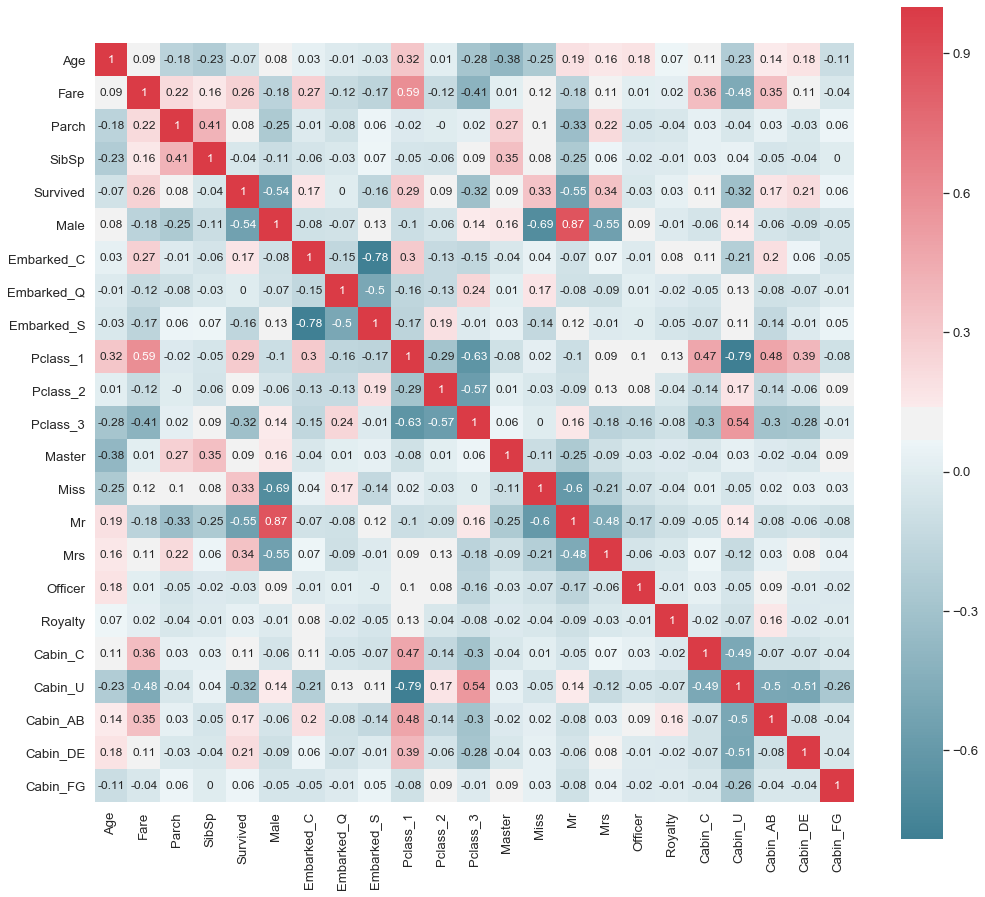

In [22]:
#Correlação entre as características.
#Pode dar uma ideia do que está relacionado com o que.
plot_correlation_map(train,figsize=(17,17))

In [23]:
%%time
#g = sns.pairplot(train,vars=train.columns[:-1], hue='Survived')#, palette = 'seismic',size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
#g.savefig("output.png")

Wall time: 0 ns


### Split Dados

Vamos utilizar 3 bases de dados diferentes para os testes:
 - __full__: todas as colunas
 - __less__: somente as colunas mais relevantes
 - __pca16__: PCA 16 da base full
 - __pca10__: PCA 10 da base full

Para a base __less__ removemos:
 - Officer, Royalty e Cabin_FG por terem pouco amostras positivas.
 - Mr por ter alta correlação com Male.
 - Embarked_Q e P_Class_2 por terem pouca correlação com a sobrevivência e por serem o complementares das restantes.  

In [24]:
from sklearn.decomposition import PCA

#A partir apenas das amostras do arquivo train.csv, cria a base de treinamento e teste.
X = full[0:train.shape[0]]
y = survived
X = X.drop(['Survived'],axis=1)

#dados full
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X, y, train_size = .7)
print("full shape",X_train_full.shape)

#dados less
X_less = X[['Age', 'Fare', 'Parch', 'SibSp', 'Male', 'Embarked_C',
            'Embarked_S', 'Pclass_1', 'Pclass_3', 'Master', 'Miss', 
            'Mrs', 'Cabin_C', 'Cabin_U', 'Cabin_AB','Cabin_DE']]
X_train_less, X_test_less, y_train_less, y_test_less = train_test_split(X_less, y, train_size = .7)
print("less shape",X_train_less.shape)

#dados pca
pca16 = PCA(n_components=16)
X_pca16 = pca16.fit_transform(X)
X_train_pca16, X_test_pca16, y_train_pca16, y_test_pca16 = train_test_split(X_pca16 , y, train_size = .7)
print("pca16 shape",X_train_pca16.shape)

pca10 = PCA(n_components=10)
X_pca10 = pca10.fit_transform(X)
X_train_pca10, X_test_pca10, y_train_pca10, y_test_pca10 = train_test_split(X_pca10 , y, train_size = .7)
print("pca10 shape",X_train_pca10.shape)

full shape (623, 22)
less shape (623, 16)
pca16 shape (623, 16)
pca10 shape (623, 10)


***
# Processo de Classificação

In [25]:
from sklearn.model_selection import GridSearchCV

In [26]:
#DataFrame para a apresentação dos resultados de forma resumida
df_resumo = pd.DataFrame(columns=['Modelo',"Tabela","Accuracy","F-measure","Preditor"])

### Função de Avaliação

In [27]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
sns.set(font_scale=1.2)

#Função utilizada para avaliar todos os modelos
def avalia_resultado(y, y_pred):
    
    fig, axs = plt.subplots(ncols=2,figsize=(12,4))
    
    #Confusion Matrix
    sns.set(font_scale=1.2)
    confusionMatrix = confusion_matrix(y, y_pred)
    
    df_cm = pd.DataFrame(confusionMatrix, index=["Died","Survived"],columns=["Died","Survived"])
    sns.heatmap(df_cm, annot=True, ax=axs[0])
    
    #Curva de Roc
    sns.set(font_scale=1)
    y_pred_2colunas = np.zeros((len(y_pred),2))
    y_pred_2colunas[range(len(y_pred)),y_pred.astype(int)] = 1
    skplt.metrics.plot_roc(y,y_pred_2colunas,plot_micro=False,plot_macro=False, ax=axs[1])

    #Avalia métricas
    report = classification_report(y, y_pred, target_names=["Died","Survived"],output_dict = True)
    df_report = pd.DataFrame(report)
    
    plt.show()
    return df_report

### KNN

In [28]:
from sklearn import neighbors

full:


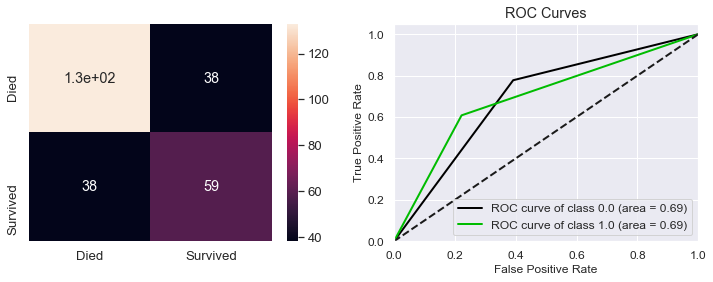

                 Died   Survived  accuracy   macro avg  weighted avg
f1-score     0.777778   0.608247  0.716418    0.693013      0.716418
precision    0.777778   0.608247  0.716418    0.693013      0.716418
recall       0.777778   0.608247  0.716418    0.693013      0.716418
support    171.000000  97.000000  0.716418  268.000000    268.000000
{'n_neighbors': 3}
less:


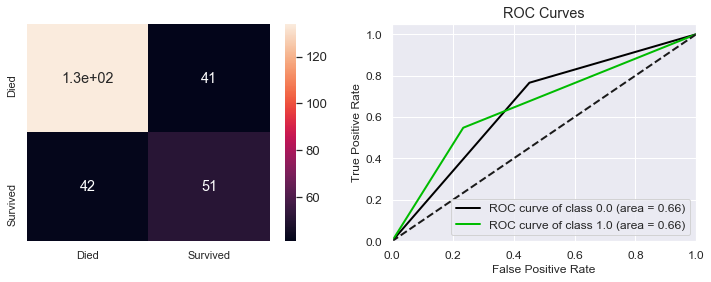

                 Died   Survived  accuracy   macro avg  weighted avg
f1-score     0.763533   0.551351  0.690299    0.657442      0.689903
precision    0.761364   0.554348  0.690299    0.657856      0.689526
recall       0.765714   0.548387  0.690299    0.657051      0.690299
support    175.000000  93.000000  0.690299  268.000000    268.000000
{'n_neighbors': 7}
pca16:


C:\Python36\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


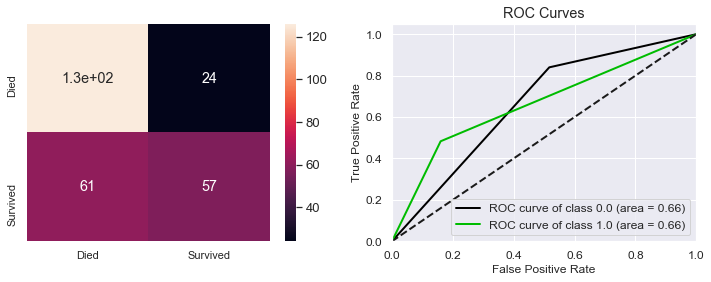

                 Died    Survived  accuracy   macro avg  weighted avg
f1-score     0.747774    0.572864  0.682836    0.660319      0.670762
precision    0.673797    0.703704  0.682836    0.688750      0.686965
recall       0.840000    0.483051  0.682836    0.661525      0.682836
support    150.000000  118.000000  0.682836  268.000000    268.000000
{'n_neighbors': 13}
pca10:


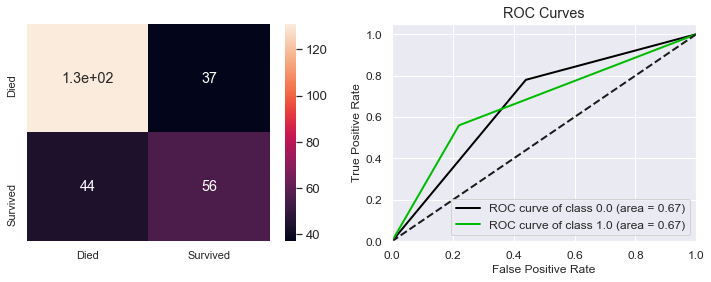

                 Died    Survived  accuracy   macro avg  weighted avg
f1-score     0.763848    0.580311  0.697761    0.672080      0.695364
precision    0.748571    0.602151  0.697761    0.675361      0.693937
recall       0.779762    0.560000  0.697761    0.669881      0.697761
support    168.000000  100.000000  0.697761  268.000000    268.000000
{'n_neighbors': 9}
Wall time: 5.02 s


In [29]:
%%time

#Varia K de 2 em 2, a partir de 3, até 30
parameters = {'n_neighbors':np.arange(3,30,2)}

clf_nkk = neighbors.KNeighborsClassifier()

#Usa cross validation com cv = 5
clf_nkk = GridSearchCV(clf_nkk, parameters, cv=5)

#full
print("full:")
clf_nkk.fit(X_train_full, y_train_full)
preditor_full = clf_nkk.predict(X_test_full)
df_resultado = avalia_resultado(y_test_full, preditor_full)
df_resumo = df_resumo.append({"Modelo":"KNN",
                              "Tabela":"Full",
                              "Accuracy":df_resultado.at["f1-score","accuracy"],
                              "F-measure":df_resultado.at["f1-score","Survived"],
                              "Preditor":preditor_full},ignore_index=True,)
print(df_resultado)
print(clf_nkk.best_params_)

#less
print("less:")
clf_nkk.fit(X_train_less, y_train_less)
preditor_less = clf_nkk.predict(X_test_less)
df_resultado = avalia_resultado(y_test_less, preditor_less)
df_resumo = df_resumo.append({"Modelo":"KNN",
                              "Tabela":"Less",
                              "Accuracy":df_resultado.at["f1-score","accuracy"],
                              "F-measure":df_resultado.at["f1-score","Survived"],
                              "Preditor":preditor_less},ignore_index=True,)
print(df_resultado)
print(clf_nkk.best_params_)

#pca16
print("pca16:")
clf_nkk.fit(X_train_pca16, y_train_pca16)
preditor_pca16 = clf_nkk.predict(X_test_pca16)
df_resultado = avalia_resultado(y_test_pca16, preditor_pca16)
df_resumo = df_resumo.append({"Modelo":"KNN",
                              "Tabela":"pca16",
                              "Accuracy":df_resultado.at["f1-score","accuracy"],
                              "F-measure":df_resultado.at["f1-score","Survived"],
                              "Preditor":preditor_pca16},ignore_index=True,)
print(df_resultado)
print(clf_nkk.best_params_)

#pca10
print("pca10:")
clf_nkk.fit(X_train_pca10, y_train_pca10)
preditor_pca10 = clf_nkk.predict(X_test_pca10)
df_resultado = avalia_resultado(y_test_pca10, preditor_pca10)
df_resumo = df_resumo.append({"Modelo":"KNN",
                              "Tabela":"pca10",
                              "Accuracy":df_resultado.at["f1-score","accuracy"],
                              "F-measure":df_resultado.at["f1-score","Survived"],
                              "Preditor":preditor_pca10},ignore_index=True,)
print(df_resultado)
print(clf_nkk.best_params_)

### Decision Tree

In [33]:
#Função para ordenar de acordo com a acurácia
def myFunc(e):
    return e['acc']


results=[]
criterions = ["gini", "entropy"]
splitters = ["best", "random"]

#Mostra o desempenho com uma aproximação de árvores de decisão (dataset = full)
for max_depth in range(2,20):
    for criterion in criterions:
        for splitter in splitters:
            tree_clf = tree.DecisionTreeClassifier(criterion= criterion, 
                                                   splitter = splitter, max_depth = max_depth )
            tree_clf = tree_clf.fit(X, y)

            #Treina o classificador com a base de treinamento
            tree_clf.fit(X_train_full, y_train_full)

            #Testa o classificador com a base de testes
            preditor = tree_clf.predict(X_test_full)
            
            #Calcula os parâmetros de avaliação
            acc = metrics.accuracy_score(y_test_full, preditor)
            
            #Coloca o resultado na lista
            new_result = {'acc':acc, 'preditor':preditor,'splitter':splitter,
                          'criterion':criterion, 'max_depth':max_depth}
            results.append(new_result)

#Ordena em ordem decrescente de acurácia
results.sort(key=myFunc, reverse=True)

#Printa os 5 melhores resultados
for i in range(0,5):
    print("accuracy: ", results[i]['acc'],", splitter: ", results[i]['splitter'], ", criterion: ",results[i]['criterion'],
          ", max_depth: ",results[i]['max_depth'])
    
#Guarda o preditor que teve maior acurácia
preditor = results[0]['preditor']

accuracy:  0.835820895522388 , splitter:  best , criterion:  entropy , max_depth:  5
accuracy:  0.832089552238806 , splitter:  best , criterion:  entropy , max_depth:  4
accuracy:  0.8283582089552238 , splitter:  random , criterion:  entropy , max_depth:  10
accuracy:  0.8246268656716418 , splitter:  best , criterion:  entropy , max_depth:  6
accuracy:  0.8208955223880597 , splitter:  best , criterion:  gini , max_depth:  3


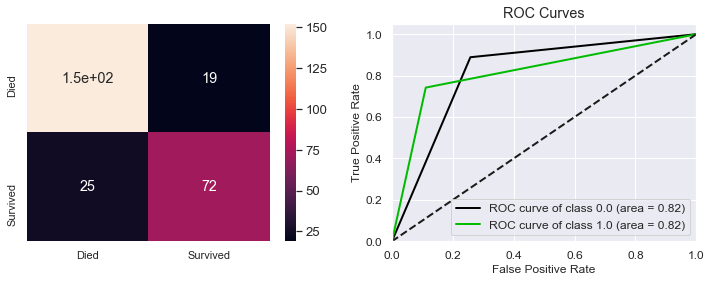

,Died,Survived,accuracy,macro avg,weighted avg
f1-score,0.873563,0.765957,0.835821,0.819760,0.834616
precision,0.858757,0.791209,0.835821,0.824983,0.834309
recall,0.888889,0.742268,0.835821,0.815578,0.835821
support,171.000000,97.000000,0.835821,268.000000,268.000000


In [34]:
#Avaliação de resultados
df_resultado = avalia_resultado(y_test_full, preditor)
df_resumo = df_resumo.append({"Modelo":"Decision Tree",
                              "Tabela":"Full",
                              "Accuracy":df_resultado.at["f1-score","accuracy"],
                              "F-measure":df_resultado.at["f1-score","Survived"],
                              "Preditor":preditor},ignore_index=True,)
df_resultado

In [35]:
#Mostra o desempenho com uma aproximação de árvores de decisão (dataset = less)
results=[]
for max_depth in range(2,20):
    for criterion in criterions:
        for splitter in splitters:
            tree_clf = tree.DecisionTreeClassifier(criterion= criterion, 
                                                   splitter = splitter, max_depth = max_depth )
            tree_clf = tree_clf.fit(X, y)

            #Treina o classificador com a base de treinamento
            tree_clf.fit(X_train_less, y_train_less)

            #Testa o classificador com a base de testes
            preditor = tree_clf.predict(X_test_less)
            
            #Calcula os parâmetros de avaliação
            acc = metrics.accuracy_score(y_test_less, preditor)
            
            #Coloca o resultado na lista
            new_result = {'acc':acc, 'preditor':preditor,'splitter':splitter,
                          'criterion':criterion, 'max_depth':max_depth}
            results.append(new_result)

#Ordena em ordem decrescente de acurácia
results.sort(key=myFunc, reverse=True)

#Printa os 5 melhores resultados
for i in range(0,5):
    print("accuracy: ", results[i]['acc'],", splitter: ", results[i]['splitter'], ", criterion: ",results[i]['criterion'],
          ", max_depth: ",results[i]['max_depth'])
    
#Guarda o preditor que teve maior acurácia
preditor = results[0]['preditor']

accuracy:  0.8395522388059702 , splitter:  random , criterion:  gini , max_depth:  3
accuracy:  0.8395522388059702 , splitter:  random , criterion:  entropy , max_depth:  3
accuracy:  0.8395522388059702 , splitter:  best , criterion:  entropy , max_depth:  6
accuracy:  0.835820895522388 , splitter:  best , criterion:  gini , max_depth:  5
accuracy:  0.835820895522388 , splitter:  best , criterion:  entropy , max_depth:  5


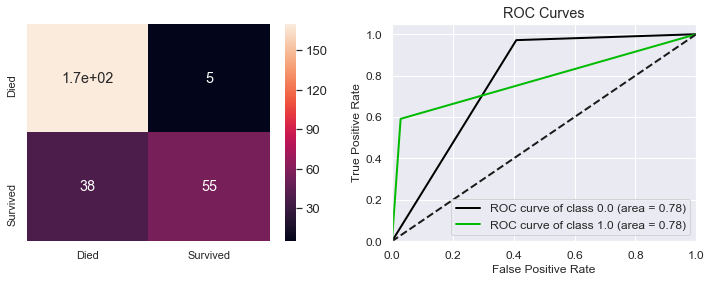

,Died,Survived,accuracy,macro avg,weighted avg
f1-score,0.887728,0.718954,0.839552,0.803341,0.829161
precision,0.817308,0.916667,0.839552,0.866987,0.851787
recall,0.971429,0.591398,0.839552,0.781413,0.839552
support,175.000000,93.000000,0.839552,268.000000,268.000000


In [36]:
#Avaliação de resultados
df_resultado = avalia_resultado(y_test_less, preditor)
df_resumo = df_resumo.append({"Modelo":"Decision Tree",
                              "Tabela":"Less",
                              "Accuracy":df_resultado.at["f1-score","accuracy"],
                              "F-measure":df_resultado.at["f1-score","Survived"],
                              "Preditor":preditor},ignore_index=True,)
df_resultado

In [37]:
#Mostra o desempenho com uma aproximação de árvores de decisão (dataset = pca16)
results=[]
for max_depth in range(2,20):
    for criterion in criterions:
        for splitter in splitters:
            tree_clf = tree.DecisionTreeClassifier(criterion= criterion, 
                                                   splitter = splitter, max_depth = max_depth )
            tree_clf = tree_clf.fit(X, y)

            #Treina o classificador com a base de treinamento
            tree_clf.fit(X_train_pca16, y_train_pca16)

            #Testa o classificador com a base de testes
            preditor = tree_clf.predict(X_test_pca16)
            
            #Calcula os parâmetros de avaliação
            acc = metrics.accuracy_score(y_test_pca16, preditor)
            
            #Coloca o resultado na lista
            new_result = {'acc':acc, 'preditor':preditor,'splitter':splitter,
                          'criterion':criterion, 'max_depth':max_depth}
            results.append(new_result)

#Ordena em ordem decrescente de acurácia
results.sort(key=myFunc, reverse=True)

#Printa os 5 melhores resultados
for i in range(0,5):
    print("accuracy: ", results[i]['acc'],", splitter: ", results[i]['splitter'], ", criterion: ",results[i]['criterion'],
          ", max_depth: ",results[i]['max_depth'])
    
#Guarda o preditor que teve maior acurácia
preditor = results[0]['preditor']

accuracy:  0.8059701492537313 , splitter:  best , criterion:  gini , max_depth:  2
accuracy:  0.8059701492537313 , splitter:  best , criterion:  gini , max_depth:  3
accuracy:  0.8022388059701493 , splitter:  best , criterion:  entropy , max_depth:  3
accuracy:  0.7985074626865671 , splitter:  best , criterion:  entropy , max_depth:  2
accuracy:  0.7985074626865671 , splitter:  random , criterion:  entropy , max_depth:  8


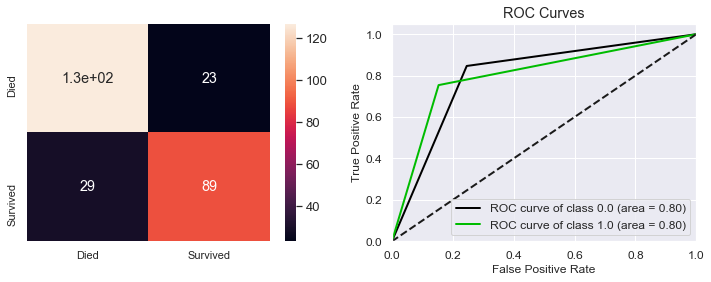

,Died,Survived,accuracy,macro avg,weighted avg
f1-score,0.830065,0.773913,0.80597,0.801989,0.805342
precision,0.814103,0.794643,0.80597,0.804373,0.805534
recall,0.846667,0.754237,0.80597,0.800452,0.805970
support,150.000000,118.000000,0.80597,268.000000,268.000000


In [38]:
#Avaliação de resultados
df_resultado = avalia_resultado(y_test_pca16, preditor)
df_resumo = df_resumo.append({"Modelo":"Decision Tree",
                              "Tabela":"pca16",
                              "Accuracy":df_resultado.at["f1-score","accuracy"],
                              "F-measure":df_resultado.at["f1-score","Survived"],
                              "Preditor":preditor},ignore_index=True,)
df_resultado

In [39]:
#Mostra o desempenho com uma aproximação de árvores de decisão (dataset = pca10)
results=[]
for max_depth in range(2,20):
    for criterion in criterions:
        for splitter in splitters:
            tree_clf = tree.DecisionTreeClassifier(criterion= criterion, 
                                                   splitter = splitter, max_depth = max_depth )
            tree_clf = tree_clf.fit(X, y)

            #Treina o classificador com a base de treinamento
            tree_clf.fit(X_train_pca10, y_train_pca10)

            #Testa o classificador com a base de testes
            preditor = tree_clf.predict(X_test_pca10)
            
            #Calcula os parâmetros de avaliação
            acc = metrics.accuracy_score(y_test_pca10, preditor)
            
            #Coloca o resultado na lista
            new_result = {'acc':acc, 'preditor':preditor,'splitter':splitter,
                          'criterion':criterion, 'max_depth':max_depth}
            results.append(new_result)

#Ordena em ordem decrescente de acurácia
results.sort(key=myFunc, reverse=True)

#Printa os 5 melhores resultados
for i in range(0,5):
    print("accuracy: ", results[i]['acc'],", splitter: ", results[i]['splitter'], ", criterion: ",results[i]['criterion'],
          ", max_depth: ",results[i]['max_depth'])
    
#Guarda o preditor que teve maior acurácia
preditor = results[0]['preditor']

accuracy:  0.8059701492537313 , splitter:  best , criterion:  entropy , max_depth:  5
accuracy:  0.8022388059701493 , splitter:  random , criterion:  entropy , max_depth:  11
accuracy:  0.7985074626865671 , splitter:  random , criterion:  entropy , max_depth:  5
accuracy:  0.7910447761194029 , splitter:  best , criterion:  entropy , max_depth:  3
accuracy:  0.7910447761194029 , splitter:  random , criterion:  gini , max_depth:  8


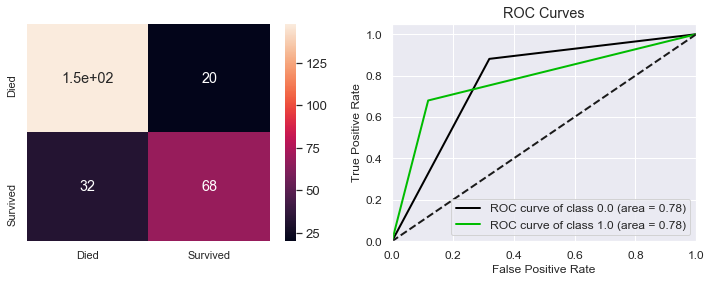

,Died,Survived,accuracy,macro avg,weighted avg
f1-score,0.850575,0.723404,0.80597,0.786989,0.803123
precision,0.822222,0.772727,0.80597,0.797475,0.803754
recall,0.880952,0.680000,0.80597,0.780476,0.805970
support,168.000000,100.000000,0.80597,268.000000,268.000000


In [40]:
#Avaliação de resultados
df_resultado = avalia_resultado(y_test_pca10, preditor)
df_resumo = df_resumo.append({"Modelo":"Decision Tree",
                              "Tabela":"pca10",
                              "Accuracy":df_resultado.at["f1-score","accuracy"],
                              "F-measure":df_resultado.at["f1-score","Survived"],
                              "Preditor":preditor},ignore_index=True,)
df_resultado

In [41]:
#printa arvore
#plt.figure(figsize=(14,8))
#a = tree.plot_tree(my_clf)

### Random Forest

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification


criterions = ["gini", "entropy"]

#Mostra o desempenho com uma aproximação de random forests (dataset = full)
results=[]
for n_estimators in range(10,100, 5):
    for criterion in criterions:
        clf = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion)
        clf.fit(X, y)

        #Treina o classificador com a base de treinamento
        clf.fit(X_train_full, y_train_full)

        #Testa o classificador com a base de testes
        preditor = clf.predict(X_test_full)

        #Calcula os parâmetros de avaliação
        acc = metrics.accuracy_score(y_test_full, preditor)

        #Coloca o resultado na lista
        new_result = {'acc':acc, 'preditor':preditor,
                      'criterion':criterion, 'n_estimators':n_estimators}
        results.append(new_result)

#Ordena em ordem decrescente de acurácia
results.sort(key=myFunc, reverse=True)

#Printa os 5 melhores resultados
for i in range(0,5):
    print("accuracy: ", results[i]['acc'], ", criterion: ",results[i]['criterion'],
          ", n_estimators: ",results[i]['n_estimators'])
    
#Guarda o preditor que teve maior acurácia
preditor = results[0]['preditor']

accuracy:  0.835820895522388 , criterion:  entropy , n_estimators:  15
accuracy:  0.835820895522388 , criterion:  gini , n_estimators:  75
accuracy:  0.8283582089552238 , criterion:  entropy , n_estimators:  55
accuracy:  0.8283582089552238 , criterion:  gini , n_estimators:  70
accuracy:  0.8283582089552238 , criterion:  entropy , n_estimators:  85


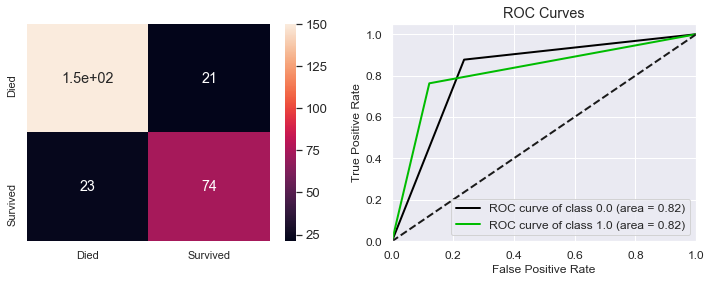

,Died,Survived,accuracy,macro avg,weighted avg
f1-score,0.872093,0.770833,0.835821,0.821463,0.835443
precision,0.867052,0.778947,0.835821,0.823000,0.835163
recall,0.877193,0.762887,0.835821,0.820040,0.835821
support,171.000000,97.000000,0.835821,268.000000,268.000000


In [43]:
#Avaliação de resultados
df_resultado = avalia_resultado(y_test_full, preditor)
df_resumo = df_resumo.append({"Modelo":"Random Forest",
                              "Tabela":"Full",
                              "Accuracy":df_resultado.at["f1-score","accuracy"],
                              "F-measure":df_resultado.at["f1-score","Survived"],
                              "Preditor":preditor},ignore_index=True,)
df_resultado

In [44]:
#Mostra o desempenho com uma aproximação de random forests (dataset = less)
results=[]
for n_estimators in range(10,100, 5):
    for criterion in criterions:
        clf = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion)
        clf.fit(X, y)

        #Treina o classificador com a base de treinamento
        clf.fit(X_train_less, y_train_less)

        #Testa o classificador com a base de testes
        preditor = clf.predict(X_test_less)

        #Calcula os parâmetros de avaliação
        acc = metrics.accuracy_score(y_test_less, preditor)

        #Coloca o resultado na lista
        new_result = {'acc':acc, 'preditor':preditor,
                      'criterion':criterion, 'n_estimators':n_estimators}
        results.append(new_result)

#Ordena em ordem decrescente de acurácia
results.sort(key=myFunc, reverse=True)

#Printa os 5 melhores resultados
for i in range(0,5):
    print("accuracy: ", results[i]['acc'], ", criterion: ",results[i]['criterion'],
          ", n_estimators: ",results[i]['n_estimators'])
    
#Guarda o preditor que teve maior acurácia
preditor = results[0]['preditor']

accuracy:  0.8432835820895522 , criterion:  entropy , n_estimators:  10
accuracy:  0.8395522388059702 , criterion:  gini , n_estimators:  10
accuracy:  0.835820895522388 , criterion:  entropy , n_estimators:  35
accuracy:  0.832089552238806 , criterion:  gini , n_estimators:  35
accuracy:  0.832089552238806 , criterion:  entropy , n_estimators:  45


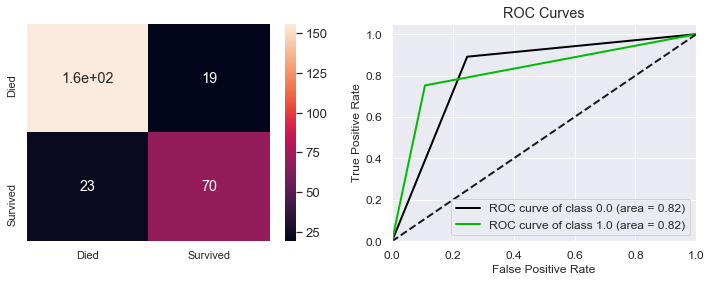

,Died,Survived,accuracy,macro avg,weighted avg
f1-score,0.881356,0.769231,0.843284,0.825293,0.842447
precision,0.871508,0.786517,0.843284,0.829013,0.842015
recall,0.891429,0.752688,0.843284,0.822058,0.843284
support,175.000000,93.000000,0.843284,268.000000,268.000000


In [45]:
#Avaliação de resultados
df_resultado = avalia_resultado(y_test_less, preditor)
df_resumo = df_resumo.append({"Modelo":"Random Forest",
                              "Tabela":"Less",
                              "Accuracy":df_resultado.at["f1-score","accuracy"],
                              "F-measure":df_resultado.at["f1-score","Survived"],
                              "Preditor":preditor},ignore_index=True,)
df_resultado

In [46]:
#Mostra o desempenho com uma aproximação de random forests (dataset = pca16)
results=[]
for n_estimators in range(10,100, 5):
    for criterion in criterions:
        clf = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion)
        clf.fit(X, y)

        #Treina o classificador com a base de treinamento
        clf.fit(X_train_pca16, y_train_pca16)

        #Testa o classificador com a base de testes
        preditor = clf.predict(X_test_pca16)

        #Calcula os parâmetros de avaliação
        acc = metrics.accuracy_score(y_test_pca16, preditor)

        #Coloca o resultado na lista
        new_result = {'acc':acc, 'preditor':preditor,
                      'criterion':criterion, 'n_estimators':n_estimators}
        results.append(new_result)

#Ordena em ordem decrescente de acurácia
results.sort(key=myFunc, reverse=True)

#Printa os 5 melhores resultados
for i in range(0,5):
    print("accuracy: ", results[i]['acc'], ", criterion: ",results[i]['criterion'],
          ", n_estimators: ",results[i]['n_estimators'])
    
#Guarda o preditor que teve maior acurácia
preditor = results[0]['preditor']

accuracy:  0.8171641791044776 , criterion:  entropy , n_estimators:  25
accuracy:  0.8171641791044776 , criterion:  entropy , n_estimators:  45
accuracy:  0.8097014925373134 , criterion:  gini , n_estimators:  55
accuracy:  0.8097014925373134 , criterion:  entropy , n_estimators:  60
accuracy:  0.8059701492537313 , criterion:  gini , n_estimators:  40


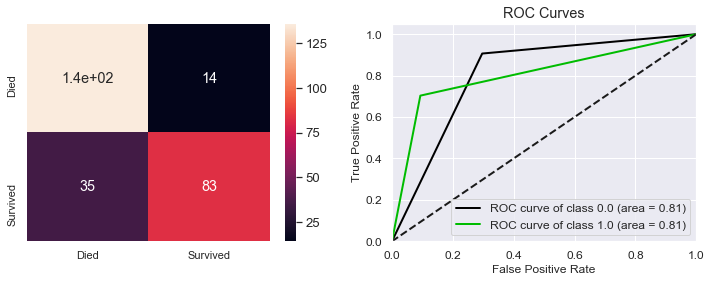

,Died,Survived,accuracy,macro avg,weighted avg
f1-score,0.847352,0.772093,0.817164,0.809723,0.814216
precision,0.795322,0.855670,0.817164,0.825496,0.821893
recall,0.906667,0.703390,0.817164,0.805028,0.817164
support,150.000000,118.000000,0.817164,268.000000,268.000000


In [47]:
#Avaliação de resultados
df_resultado = avalia_resultado(y_test_pca16, preditor)
df_resumo = df_resumo.append({"Modelo":"Random Forest",
                              "Tabela":"pca16",
                              "Accuracy":df_resultado.at["f1-score","accuracy"],
                              "F-measure":df_resultado.at["f1-score","Survived"],
                              "Preditor":preditor},ignore_index=True,)
df_resultado

In [48]:
#Mostra o desempenho com uma aproximação de random forests (dataset = pca10)
results=[]
for n_estimators in range(10,100, 5):
    for criterion in criterions:
        clf = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion)
        clf.fit(X, y)

        #Treina o classificador com a base de treinamento
        clf.fit(X_train_pca10, y_train_pca10)

        #Testa o classificador com a base de testes
        preditor = clf.predict(X_test_pca10)

        #Calcula os parâmetros de avaliação
        acc = metrics.accuracy_score(y_test_pca10, preditor)

        #Coloca o resultado na lista
        new_result = {'acc':acc, 'preditor':preditor,
                      'criterion':criterion, 'n_estimators':n_estimators}
        results.append(new_result)

#Ordena em ordem decrescente de acurácia
results.sort(key=myFunc, reverse=True)

#Printa os 5 melhores resultados
for i in range(0,5):
    print("accuracy: ", results[i]['acc'], ", criterion: ",results[i]['criterion'],
          ", n_estimators: ",results[i]['n_estimators'])
    
#Guarda o preditor que teve maior acurácia
preditor = results[0]['preditor']

accuracy:  0.8171641791044776 , criterion:  gini , n_estimators:  10
accuracy:  0.8134328358208955 , criterion:  gini , n_estimators:  20
accuracy:  0.8134328358208955 , criterion:  entropy , n_estimators:  35
accuracy:  0.8134328358208955 , criterion:  entropy , n_estimators:  80
accuracy:  0.8097014925373134 , criterion:  entropy , n_estimators:  60


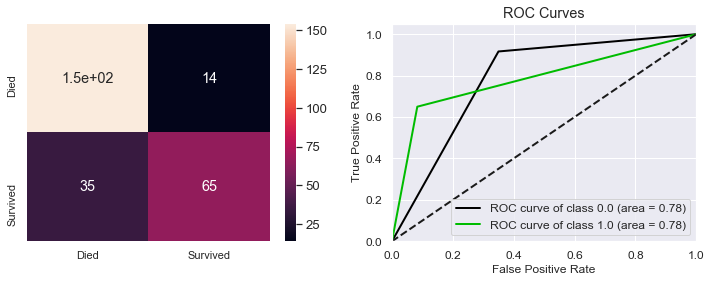

,Died,Survived,accuracy,macro avg,weighted avg
f1-score,0.862745,0.726257,0.817164,0.794501,0.811817
precision,0.814815,0.822785,0.817164,0.818800,0.817789
recall,0.916667,0.650000,0.817164,0.783333,0.817164
support,168.000000,100.000000,0.817164,268.000000,268.000000


In [49]:
#Avaliação de resultados
df_resultado = avalia_resultado(y_test_pca10, preditor)
df_resumo = df_resumo.append({"Modelo":"Random Forest",
                              "Tabela":"pca10",
                              "Accuracy":df_resultado.at["f1-score","accuracy"],
                              "F-measure":df_resultado.at["f1-score","Survived"],
                              "Preditor":preditor},ignore_index=True,)
df_resultado

### Gaussian Naive Bayes

In [50]:
from sklearn import datasets
from sklearn.naive_bayes import GaussianNB

#Mostra o desempenho com uma aproximação naive bayes (full)
gnb = GaussianNB()
gnb.fit(X, y)

#Testa o classificador com a base de testes
preditor = gnb.predict(X_test_full)

#Mostra a acurácia
acc = metrics.accuracy_score(y_test_full, preditor)
print("\nAccuracy\n", acc)


Accuracy
 0.7798507462686567


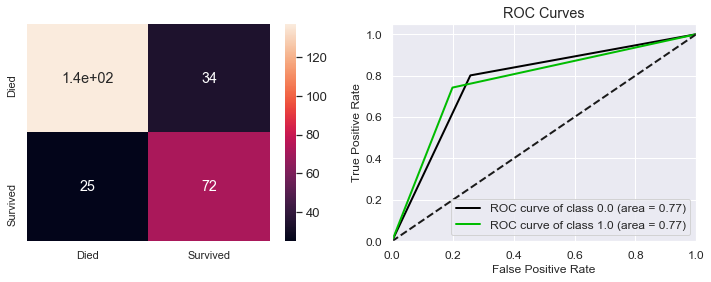

,Died,Survived,accuracy,macro avg,weighted avg
f1-score,0.822823,0.709360,0.779851,0.766091,0.781756
precision,0.845679,0.679245,0.779851,0.762462,0.785440
recall,0.801170,0.742268,0.779851,0.771719,0.779851
support,171.000000,97.000000,0.779851,268.000000,268.000000


In [51]:
#Avaliação de resultados
df_resultado = avalia_resultado(y_test_full, preditor)
df_resumo = df_resumo.append({"Modelo":"GaussianNB",
                              "Tabela":"Full",
                              "Accuracy":df_resultado.at["f1-score","accuracy"],
                              "F-measure":df_resultado.at["f1-score","Survived"],
                              "Preditor":preditor},ignore_index=True,)
df_resultado

***
# Resumo

In [52]:
#Utiliza a estrutura previamente criada para printar os resultados de forma resumida
df_resumo[["Modelo","Tabela","Accuracy","F-measure"]]

,Modelo,Tabela,Accuracy,F-measure
0,KNN,Full,0.716418,0.608247
1,KNN,Less,0.690299,0.551351
2,KNN,pca16,0.682836,0.572864
3,KNN,pca10,0.697761,0.580311
4,Decision Tree,Full,0.835821,0.765957
5,Decision Tree,Less,0.839552,0.718954
6,Decision Tree,pca16,0.805970,0.773913
7,Decision Tree,pca10,0.805970,0.723404
8,Random Forest,Full,0.835821,0.770833
9,Random Forest,Less,0.843284,0.769231


### Curva ROC:

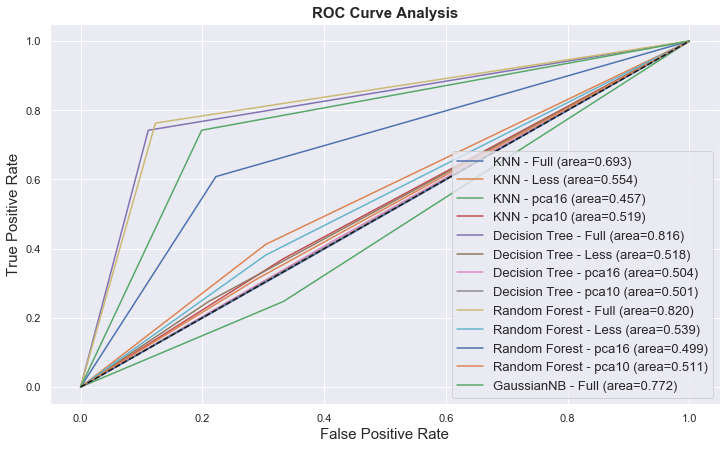

In [53]:
from sklearn.metrics import roc_curve, roc_auc_score
fig = plt.figure(figsize=(12,7))

#Plot de cada curva
for index, row in df_resumo.iterrows():
    fpr, tpr, _ = roc_curve(y_test_full, row.Preditor)
    area        = roc_auc_score(y_test_full, row.Preditor)
    label       = "%s - %s (area=%.3f)"%(row.Modelo,row.Tabela,area)
    
    plt.plot(fpr, tpr,label=label)
    
#Linha base
plt.plot([0,1], [0,1], color='k', linestyle='--')

#legendas
plt.xlabel("False Positive Rate", fontsize=15)
plt.ylabel("True Positive Rate", fontsize=15)
plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13})

plt.show()

# Coisas que daria para fazer
 - arrumar ou remover as idades inválidas
 - documentar mais o notebook explicando nossas escolhas e raciocínio
 - testar todas as abordagens com todas as colunas, com menos colunas e utilizando PCA
  - com menos colunas podemos remover Officer, Royalty, Cabin_FG (por terem pouco amostras), Mr (por ter alta correlação com Male) e/ou qualquer outra que não tenha muita importância.
 - testar se melhora o resultado não separar colunas que tem algum significado contínuo ex: Cabin e Pclass (só teria que lembrar de transformar em variável numérica) 
 - utilizar grid search e/ou random search
 - <strike> utilizar diferentes métricas e visualizações dos resultados.</strike>
 - <strike> criar um resumo final com todos os resultados.</strike>
 - <strike> criar uma curva ROC com todos os resultados.</strike>
